In [25]:
import pandas as pd
import numpy as np
from river import compose, preprocessing, metrics, tree, stream, drift
import matplotlib.pyplot as plt

## Global model

Starting online learning...
Final Model Performance: MAE: 19.089818
R2: 0.985898
Number of drifts detected: 263


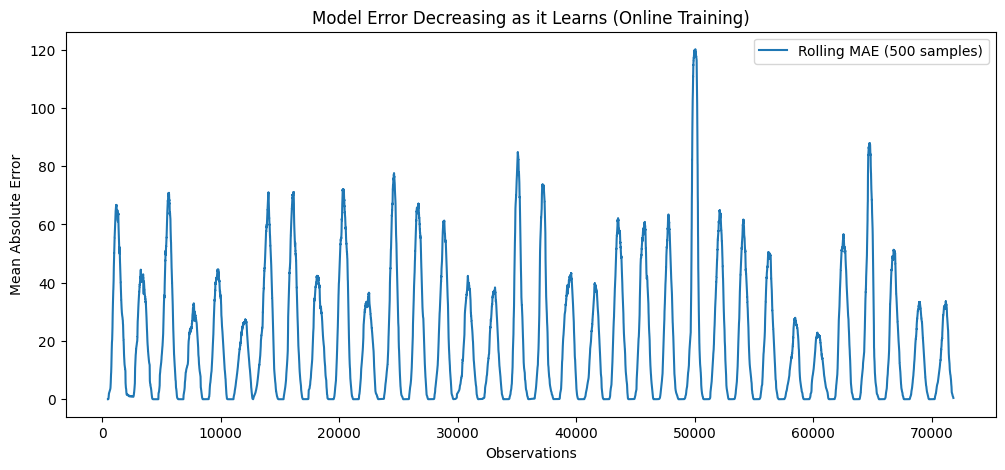

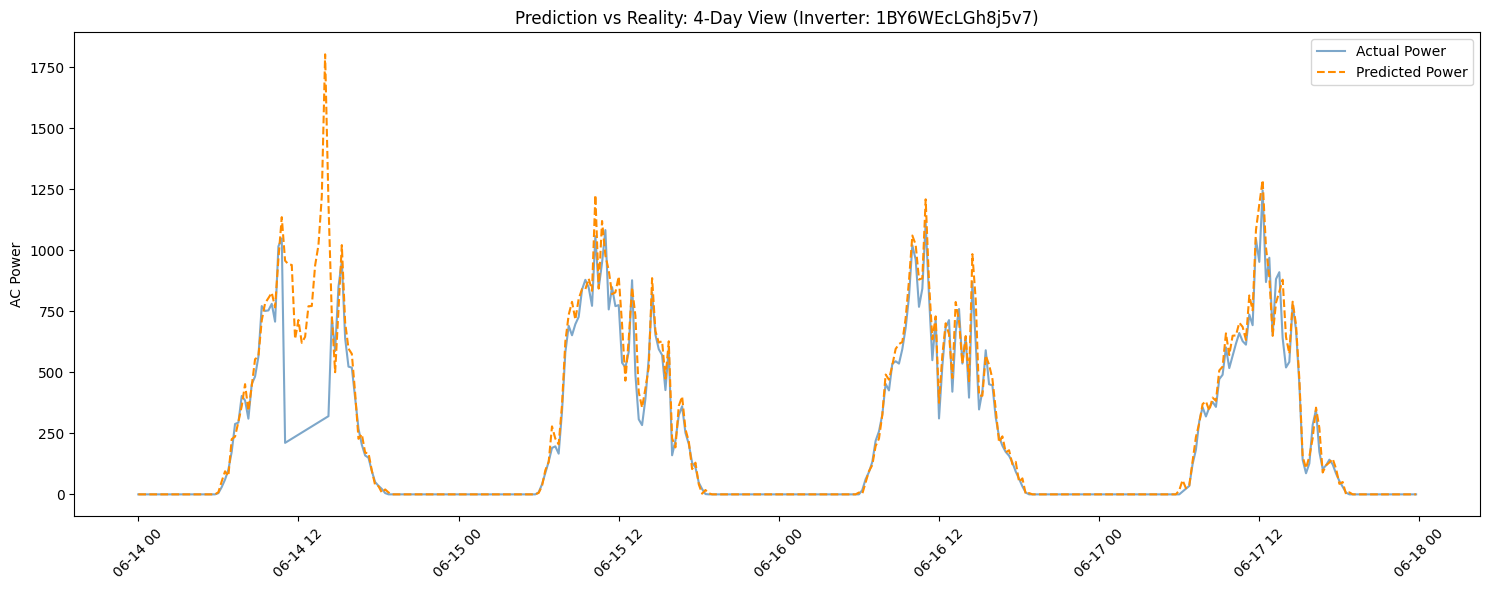

In [ ]:
df = pd.read_csv('cleaned_data/solar_1.csv')
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

df['hour_sin'] = df['DATE_TIME'].dt.hour.apply(lambda h: np.sin(2 * np.pi * h / 24))
df['hour_cos'] = df['DATE_TIME'].dt.hour.apply(lambda h: np.cos(2 * np.pi * h / 24))
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour_sin', 'hour_cos']
target = 'AC_POWER'

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeRegressor(
        grace_period=100,
        model_selector_decay=0.9
    )
)

metric = metrics.MAE() + metrics.R2()
adwin = drift.ADWIN(delta=0.002)

print("Starting online learning...")

preds = []
actuals = []
drift_events = []

for i, (x, y) in enumerate(stream.iter_pandas(df[features], df[target])):
    y_pred = model.predict_one(x)

    error = abs(y - (y_pred or 0))
    adwin.update(error)
    if adwin.drift_detected:
        drift_events.append(i)

    metric.update(y, y_pred)
    preds.append(y_pred)
    actuals.append(y)
    model.learn_one(x, y)

print(f"Final Model Performance: {metric}")
print(f"Number of drifts detected: {len(drift_events)}") # TODO: decide what to do with the drift detection

results = pd.DataFrame({'Actual': actuals, 'Predicted': preds})
results['MAE_Rolling'] = (results['Actual'] - results['Predicted']).abs().rolling(500).mean()

plt.figure(figsize=(12, 5))
plt.plot(results['MAE_Rolling'], label='Rolling MAE (500 samples)')
plt.title('Model Error Decreasing as it Learns (Online Training)')
plt.xlabel('Observations')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

eval_df = pd.DataFrame({
    'DATE_TIME': df['DATE_TIME'],
    'SOURCE_KEY': df['SOURCE_KEY'],
    'Actual': actuals,
    'Predicted': preds
})
sample_inverter = eval_df['SOURCE_KEY'].unique()[0]
inverter_data = eval_df[eval_df['SOURCE_KEY'] == sample_inverter]

plt.figure(figsize=(15, 6))
last_days = inverter_data.tail(96 * 4) 

plt.plot(last_days['DATE_TIME'], last_days['Actual'], label='Actual Power', alpha=0.7, color='steelblue')
plt.plot(last_days['DATE_TIME'], last_days['Predicted'], label='Predicted Power', linestyle='--', color='darkorange')

plt.title(f'Prediction vs Reality: 4-Day View (Inverter: {sample_inverter})')
plt.ylabel('AC Power')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Single models for each inverter

Starting online learning for 22 inverters...

Final Performance Summary (First 5 Inverters):
Inverter 1BY6WEcLGh8j5v7: MAE: 37.115789
R2: 0.961639
Inverter 1IF53ai7Xc0U56Y: MAE: 29.567406
R2: 0.983263
Inverter 3PZuoBAID5Wc2HD: MAE: 33.139841
R2: 0.978374
Inverter 7JYdWkrLSPkdwr4: MAE: 27.833093
R2: 0.983883
Inverter McdE0feGgRqW7Ca: MAE: 31.171358
R2: 0.977961

Total Drifts Detected: 706


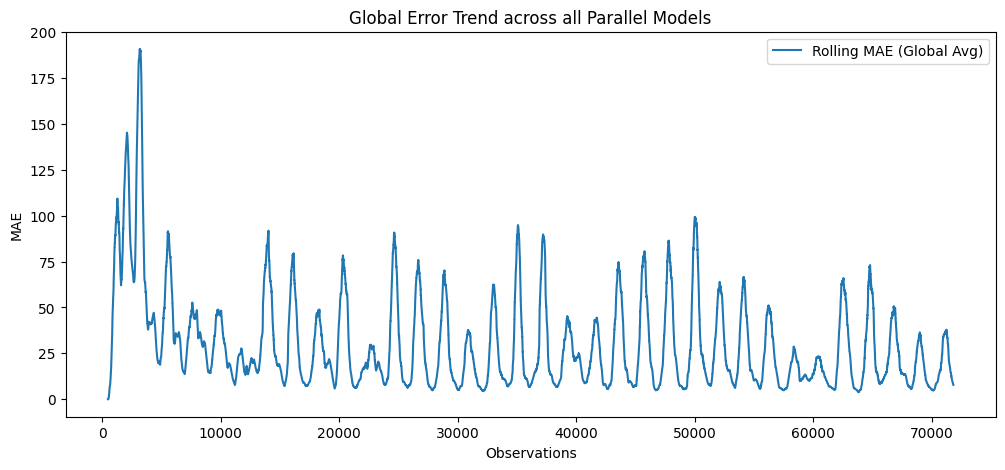

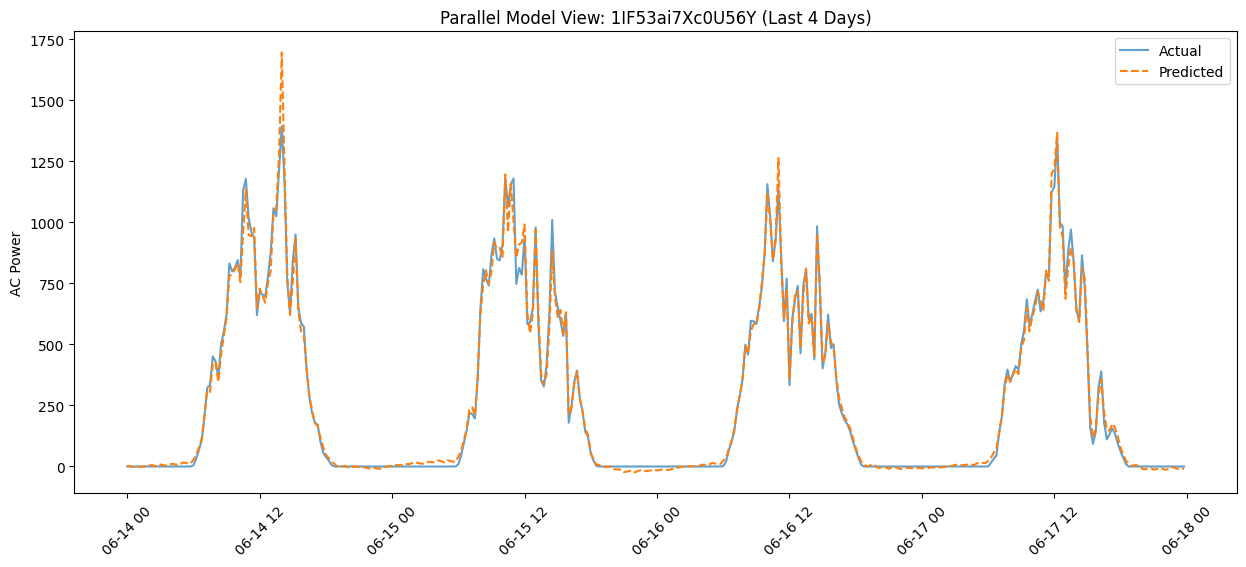

In [35]:
unique_inverters = df['SOURCE_KEY'].unique()
models = {}
metrics_dict = {}
adwins = {}

for sn in unique_inverters:
    models[sn] = compose.Pipeline(
        preprocessing.StandardScaler(),
        tree.HoeffdingTreeRegressor(
            grace_period=100,
            model_selector_decay=0.9
        )
    )
    metrics_dict[sn] = metrics.MAE() + metrics.R2()
    adwins[sn] = drift.ADWIN(delta=0.002)

preds = []
actuals = []
drift_events = []

print(f"Starting online learning for {len(unique_inverters)} inverters...")

for i, (x, y) in enumerate(stream.iter_pandas(df[features + ['SOURCE_KEY']], df[target])):
    sn = x.pop('SOURCE_KEY') 

    model = models[sn]
    metric = metrics_dict[sn]
    adwin = adwins[sn]

    y_pred = model.predict_one(x)

    error = abs(y - (y_pred or 0))
    adwin.update(error)
    if adwin.drift_detected:
        drift_events.append((i, sn))

    metric.update(y, y_pred)
    preds.append(y_pred)
    actuals.append(y)

    model.learn_one(x, y)

print("\nFinal Performance Summary (First 5 Inverters):")
for sn in list(unique_inverters)[:5]:
    print(f"Inverter {sn}: {metrics_dict[sn]}")

print(f"\nTotal Drifts Detected: {len(drift_events)}")

results = pd.DataFrame({'Actual': actuals, 'Predicted': preds})
results['MAE_Rolling'] = (results['Actual'] - results['Predicted']).abs().rolling(500).mean()

plt.figure(figsize=(12, 5))
plt.plot(results['MAE_Rolling'], label='Rolling MAE (Global Avg)')
plt.title('Global Error Trend across all Parallel Models')
plt.xlabel('Observations')
plt.ylabel('MAE')
plt.legend()
plt.show()

eval_df = pd.DataFrame({
    'DATE_TIME': df['DATE_TIME'],
    'SOURCE_KEY': df['SOURCE_KEY'],
    'Actual': actuals,
    'Predicted': preds
})

sample_inverter = unique_inverters[1]
in_data = eval_df[eval_df['SOURCE_KEY'] == sample_inverter].tail(96 * 4) 

plt.figure(figsize=(15, 6))
plt.plot(in_data['DATE_TIME'], in_data['Actual'], label='Actual', alpha=0.7)
plt.plot(in_data['DATE_TIME'], in_data['Predicted'], label='Predicted', linestyle='--')
plt.title(f'Parallel Model View: {sample_inverter} (Last 4 Days)')
plt.ylabel('AC Power')
plt.legend()
plt.xticks(rotation=45)
plt.show()